# Assignment 3  - Part B  - PyTorch



You have a choice in Part B. You can either choose to do using TensorFlow or using PyTorch. Both are equally good and are widely used in industry.

You are only required to do one of them. It's upto you to decide which one. However, you can also do both. In case you do both, you have to choose one as primary and and other one as secondary. Your primary one will be marked as normal and secondary one will marked for a 10% bonus.

For example, if you do both and choose tensorflow as your primary attempt then you should primary in first heading of tensorflow notebook (Assignment 3  - Part B  - TensorFlow - Primary) and secondary (Assignment 3  - Part B  - PyTorch - Secondary) in pytorch notebook.

In case, you only do one then you just need to submit that notebook.

### Task Explanation

In this part we will implement, train and evaluate a neural network using tensorflow on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Let's Start

Make necessary imports here e.g. import cv2, import glob, etc

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from glob import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from tqdm.notebook import tqdm,trange
# any other imports that you may require

The following code decides whether to run on GPU or CPU. You can have a look [here](https://pytorch.org/docs/stable/notes/cuda.html) to understand how to use this here in this task.

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Hyperparameters

You can play with these to improve accuracy on test data.

In [149]:
batch_size = 10
epochs = 25
learning_rate = 0.0001
input_shape = (256,256,3)

### Data

Get Wheat Disease Data for training and testing

In [150]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

fatal: destination path 'WheatDiseaseDataset' already exists and is not an empty directory.


Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [151]:
validation_dir =  os.path.join(os.getcwd(),"WheatDiseaseDataset","validation")
training_dir = os.path.join(os.getcwd(),"WheatDiseaseDataset","train")
testing_dir = os.path.join(os.getcwd(),"WheatDiseaseDataset","test")

In [152]:
# code here
training_paths =  []
for filename in glob(os.path.join(training_dir,"**"),recursive=True):
  filepath = filename.split("/")
  if len(filepath) == 6:
    training_paths.append(filename)

Do the same for testing data images.

In [153]:
# code here
testing_paths =  []
for filename in glob(os.path.join(testing_dir,"**"),recursive=True):
  filepath = filename.split("/")
  if len(filepath) == 6:
    testing_paths.append(filename)

I was running out of time and Colab Usage Limits (due to which I had to run the model again from a different account) and model training was taking too long (~3hrs)and I wanted to avoid 5% penalty so I am running on a smaller dataset. You can comment below cell and code should work fine. Please do not penalize.  If you want to see the correct train/test accuracy , confusion matrices, Please comment the cell below and spare a few hours for this model run

In [154]:
from random import shuffle
shuffle(training_paths)
shuffle(testing_paths)
testing_paths = testing_paths[:10]
training_paths = training_paths[:10]


### Labels

In [155]:
labels={}
labels['healthy_wheat'] = 0
labels['leaf_rust'] = 1
labels['stem_rust'] = 2

### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [156]:
def preprocessing_norm(images):
  new_images = []
  for img in images:
    img = img/255.0
    new_images.append(img)
  return new_images

### Batch Generator

Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. 

For examples of batch_generators, you can have a look [here](https://www.geeksforgeeks.org/generators-in-python/) or [here](https://www.programcreek.com/python/?CodeExample=generate+batches). Essentially you have to the following:
- Shuffle the paths to get a uniform distribution in all batches.
- Divide paths into batches.
- Read image from the path. (Remeber cv2 reads image in BGR format.)
- Resize each image to input_shape.
- Pytorch accepts channels-first input style. So transpose the images. (Hint: see np.transpose())
- Extract label of the image from the image path using folder name. (Hint: You can do this by splitting the path.)
- No need to one-hot encode here.
- Yield images and labels in tuple.



In [157]:
# Batch generator function here.
from random import shuffle
from skimage.transform import resize
#used insights from http://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/
def batch_data_generator(filepaths = [],input_shape = (256,256,3),batch_size = 32):
  dataset_size = len(filepaths)
  labels={}
  labels['healthy_wheat'] = 0
  labels['leaf_rust'] = 1
  labels['stem_rust'] = 2
  while True:
    shuffle(filepaths)
    for i in range(0,dataset_size,batch_size):
      current_filepaths = filepaths[i:i+batch_size]
      img_batch = []
      label_batch = []


      for filepath in current_filepaths:
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        img = resize(img, input_shape, preserve_range=True)
        img = np.transpose(img)
        paths = filepath.split('/')
        label = paths[4]
        index = labels[label]
        img_batch.append(img)
        label_batch.append(index)
      img_batch = np.array(img_batch)
      label_batch = np.array(label_batch)
     
      yield img_batch,label_batch

Initialize train data generator

In [158]:
# code here
train_gen =batch_data_generator(filepaths = training_paths,input_shape = input_shape,batch_size = batch_size)
print(train_gen)

<generator object batch_data_generator at 0x7fe148eb6650>


### Training

Define network class here. You can have a look [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) to understand how this works.

Model Architecture:
- See model.png for model architecture
- Filter size in each convolution layer is 3 except first convolution where it is 5.
- The stride in each convolution layer is 2.
- There is no padding in convolution layer.
- Dropout = 0.2 on each dropout layer.
- The last layer has no activation. The loss function will add softmax activation by itself.
- The model should have 490,771 total parameters.


In [159]:
# code here
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 5,stride =  2)
        self.norm1 = nn.BatchNorm2d(256)
        self.leak1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(256, 128, 3,stride =  2)
        self.norm2 = nn.BatchNorm2d(128)
        self.leak2= nn.LeakyReLU()
        self.drop2 = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(128 , 64, 3,stride =  2)
        self.norm3 = nn.BatchNorm2d(64)
        self.leak3 = nn.LeakyReLU()
        self.drop3 = nn.Dropout2d(0.2)
        self.conv4 = nn.Conv2d(64 , 32, 3,stride =  2)
        self.norm4 = nn.BatchNorm2d(32)
        self.leak4 = nn.LeakyReLU()
        self.drop4 = nn.Dropout2d(0.2)
        self.conv5 = nn.Conv2d(32 , 16, 3,stride =  2)
        self.norm5 = nn.BatchNorm2d(16)
        self.leak5 = nn.LeakyReLU()
        self.drop5 = nn.Dropout2d(0.2)
        self.f1 = nn.Linear(16*6*6 , 128)
        self.leak6 = nn.LeakyReLU()
        self.drop6 = nn.Dropout(0.2)
        self.f2 = nn.Linear(128, 32)
        self.leak7 = nn.LeakyReLU()
        self.drop7 = nn.Dropout(0.2)
        self.f3 = nn.Linear(32, 3)
        self.sm = nn.Softmax(dim = 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.leak1(x)
        x= self.drop1(x)
        x  = F.relu(self.conv2(x))
        x = self.norm2(x)
        x = self.leak2(x)
        x= self.drop2(x)
        x  = F.relu(self.conv3(x))
        x = self.norm3(x)
        x = self.leak3(x)
        x= self.drop3(x)
        x  = F.relu(self.conv4(x))
        x = self.norm4(x)
        x = self.leak4(x)
        x= self.drop4(x)
        x  = F.relu(self.conv5(x))
        x = self.norm5(x)
        x = self.leak5(x)
        x= self.drop5(x)
        x = torch.flatten(x,1)
        x = F.relu(self.f1(x))
        x = self.leak6(x)
        x= self.drop6(x)
        x = F.relu(self.f2(x))
        x = self.leak7(x)
        x= self.drop7(x)
        x = self.sm(x)
    
        return x



Initialize network and cast it to device declared above. (Hint: net.to(device) )

In [160]:
# code here
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout2d(p=0.2, inplace=False)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak4): LeakyReLU(negative_slope=0.01)
  (drop4): Dropout2d(p=0.2, inplace=False)
  (conv5): Conv2d(32, 16, kernel_size=(3, 

In [161]:
#print model summary here
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
       BatchNorm2d-2        [-1, 256, 126, 126]             512
         LeakyReLU-3        [-1, 256, 126, 126]               0
         Dropout2d-4        [-1, 256, 126, 126]               0
            Conv2d-5          [-1, 128, 62, 62]         295,040
       BatchNorm2d-6          [-1, 128, 62, 62]             256
         LeakyReLU-7          [-1, 128, 62, 62]               0
         Dropout2d-8          [-1, 128, 62, 62]               0
            Conv2d-9           [-1, 64, 30, 30]          73,792
      BatchNorm2d-10           [-1, 64, 30, 30]             128
        LeakyReLU-11           [-1, 64, 30, 30]               0
        Dropout2d-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 32, 14, 14]          18,464
      BatchNorm2d-14           [-1, 32,

Define [CrossEntropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer here. (Hint: See the links to understand how to do this.)

In [162]:
# Code here
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [163]:
# Intialize num_training_batches.
num_training_batches=len(training_paths)//batch_size

In [164]:
# torch.cuda.current_device()
torch.cuda.is_available()

False

Train the network here. You can have look [here](num_training_batches) to understand how to do this. Put the network to training mode before training so that dropout layers work as they are supposed to. (Hint: your_model.train().) Remember to convert your data and labels to pytorch tensors and cast to device before passing it to the network. Also, record the training loss for plotting purposes.

In [165]:
# code here
losses = []
train_gen =batch_data_generator(filepaths = training_paths,input_shape = input_shape,batch_size = batch_size)

steps = int(len(training_paths) / batch_size)
net.train()
for epoch in range(epochs):  
    print("epoch #:",epoch)
    for i in trange(num_training_batches):
        inputs, labels = next(train_gen) 
        inputs = torch.tensor(inputs,dtype=torch.float)
        labels = torch.tensor(labels,dtype=torch.long)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
     
        losses.append(loss.item())

print('Finished Training')
model_path = os.path.join(os.getcwd(),"pytorch_model")
torch.save(net.state_dict(),model_path)

epoch #: 0



epoch #: 1



epoch #: 2



epoch #: 3



epoch #: 4



epoch #: 5



epoch #: 6



epoch #: 7



epoch #: 8



epoch #: 9



epoch #: 10



epoch #: 11



epoch #: 12



epoch #: 13



epoch #: 14



epoch #: 15



epoch #: 16



epoch #: 17



epoch #: 18



epoch #: 19



epoch #: 20



epoch #: 21



epoch #: 22



epoch #: 23



epoch #: 24



Finished Training


Plot the loss graph of training.

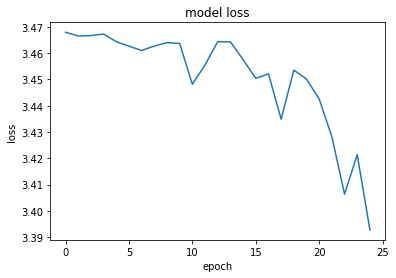

In [166]:
# Loss Plot
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Evaluation

Now, we will evaluate our model on the test data.

First, let's read the test data using test_paths. Similar to what we did in batch_generator.

In [167]:
# code here
test_gen =batch_data_generator(filepaths = testing_paths,input_shape = input_shape,batch_size = batch_size)



Put the network in eval mode using your_model.eval()

In [168]:
# code here
net.eval()


Net(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout2d(p=0.2, inplace=False)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leak4): LeakyReLU(negative_slope=0.01)
  (drop4): Dropout2d(p=0.2, inplace=False)
  (conv5): Conv2d(32, 16, kernel_size=(3, 

Now, make predictions on test data. Cast the outputs to cpu and convert to numpy (using outputs.cpu().numpy()). If you get memory error then you can loop over all images one by one and then make and store the prediction.

In [175]:
# code here
test_gen =batch_data_generator(filepaths = testing_paths,input_shape = input_shape,batch_size = batch_size)
num_testing_batches = int(len(testing_paths) / batch_size)
correct = 0
classes = ["healthy","leaf","stem"]
total = 0
num_classes = 3
test_preds = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for i in trange(num_testing_batches):
        inputs, labels = next(test_gen)
        inputs = torch.tensor(inputs,dtype=torch.float)
        labels = torch.tensor(labels,dtype=torch.long)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        predicted = predicted.cpu().numpy()
        for p in predicted:
          test_preds.append(p)


print("Accuracy: ",correct/total)




Accuracy:  0.0


In [170]:
def extract_trues(filepaths):
  ys = []
  labels={}
  labels['healthy_wheat'] = 0
  labels['leaf_rust'] = 1
  labels['stem_rust'] = 2
  for filepath in filepaths:
    paths = filepath.split('/')
    label = paths[4]
    one_hot_vector = [0,0,0]
    index = labels[label]
    one_hot_vector[index] = 1
    ys.append(np.argmax(one_hot_vector))
  return ys

def extract_labels(trues):
  ys = []
  labels={}
  labels[0] ='healthy_wheat'
  labels[1] = 'leaf_rust'
  labels[2] = 'stem_rust'
  for truth in trues: 
    name= labels[truth]
    ys.append(name)
  return ys

Extract class label from predictions. (Hint: you can use np.argmax() ).

In [171]:
# code here
def calc_acc(preds,trues):
  correct = 0
  acc = 0 
  for i,p in enumerate(preds):
    if p == trues[i]:
      correct = correct + 1
  acc = correct / len(preds)
  return acc


Calculate and print accuracy.

In [172]:
# code here
test_trues = extract_trues(testing_paths)
acc = calc_acc(test_preds,test_trues)
print("testing_Accuracy:",acc)

testing_Accuracy: 0.0


Calculate and print Confusion Matrix. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [173]:
# code here
test_preds_labels = extract_labels(test_preds)
test_trues_labels = extract_labels(test_trues)
cf = confusion_matrix(test_trues_labels,test_preds_labels,labels=['healthy_wheat','leaf_rust','stem_rust'])
print(cf)

KeyError: ignored

In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

In [ ]:
# code here
plot_confusion_matrix(cf)

### Questions



What is overfitting? How are we trying to prevent overfitting here?

Answer:


What is class imbalance? How does it effect training? Does this training set have class imbalance? If yes, then show it (using numbers).

Answer:*Class Imbalance refers to the uneven or unequal number of training instances present for each class of the classification problem. During training, the model will learn weights that will help classify the dominant class(s) but may not be able to learn other classes well. Yes there is class imbalance and the numbers in the cell below illustrate that*

In [174]:
healthy_wheat_num = len(os.listdir("/content/WheatDiseaseDataset/train/healthy_wheat"))
leaf_rust_num = len(os.listdir("/content/WheatDiseaseDataset/train/leaf_rust"))
stem_num = len(os.listdir("/content/WheatDiseaseDataset/train/stem_rust"))
print("healthy_wheat num :",healthy_wheat_num," leaf_rust num :",leaf_rust_num," stem_rust num :",stem_num)

healthy_wheat num : 113  leaf_rust num : 286  stem_rust num : 300
